In [58]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers
import keras
from google.colab import files
import matplotlib.pyplot as plt

## Constants

### Dataset constants

In [59]:
IMG_SHAPE = (64, 64)
BATCH_SIZE = 64

### Model constants

In [60]:
TIMESTEPS = 250
BETA_0 = 1e-4
BETA_T = 2e-2
EPOCHS = 50
EMA_DECAY = 0.999
widths = [3, 8, 16, 32]
has_attention = [False, False, True, True]

## Build the dataset (flowers)

In [61]:
class FlowersDataset():
    def __init__(self):
        dataset_dict = tfds.load('tf_flowers')
        self.dataset = dataset_dict['train'].map(self.preprocess_image).shuffle(1000).batch(BATCH_SIZE)

    def preprocess_image(self, image):
        # Scale to fixed size, cast it to [-1,1] and random horizontal flip
        image = tf.image.resize(image['image'], IMG_SHAPE)
        image = (tf.cast(image, tf.float32) / 127.5) - 1.0
        return tf.image.random_flip_left_right(image)

## Gaussian diffusion utilities

In [62]:
class GaussianDiffusion():
    def __init__(self):
        self.beta_0 = tf.constant(BETA_0, dtype=tf.float32)
        self.beta_T = tf.constant(BETA_T, dtype=tf.float32)
        self.T = TIMESTEPS

        self.beta = tf.linspace(self.beta_0, self.beta_T, self.T)
        self.alpha = 1 - self.beta
        self.alpha_bar = tf.math.cumprod(self.alpha)
        self.alpha_bar_prev =tf.concat([[1.0], self.alpha_bar[:-1]], axis=0)
        self.sqrt_alpha_bar = tf.sqrt(self.alpha_bar)
        self.sqrt_alpha_bar_prev = tf.sqrt(self.alpha_bar_prev)
        self.one_minus_alpha_bar_prev = 1.0 - self.alpha_bar_prev
        self.sqrt_one_minus_alpha_bar = tf.sqrt(1.0 - self.alpha_bar)
        self.reciprocal_one_minus_alpha_bar = 1.0 / (1.0 - self.alpha_bar)

        self.posterior_coeff_x0 = self.beta * self.sqrt_alpha_bar_prev * self.reciprocal_one_minus_alpha_bar
        self.posterior_coeff_xt = tf.sqrt(self.alpha) * self.one_minus_alpha_bar_prev * self.reciprocal_one_minus_alpha_bar
        self.posterior_variance = self.beta * self.one_minus_alpha_bar_prev * self.reciprocal_one_minus_alpha_bar

    def _get_values(self, tensor, indices, images):
        batch_size = tf.shape(images)[0]
        return tf.reshape(tf.gather(tensor, indices), [batch_size, 1, 1, 1])

    def sample_noisy_image(self, x_0, t):
        # x_t = mean + sqrt(variance) * noise, mean = sqrt(alpha_bar[t])*x_0, variance = 1-alpha_bar[t]
        noise = tf.random.normal(shape=(tf.shape(x_0)))
        mean = self._get_values(self.sqrt_alpha_bar, t, x_0) * x_0
        stddev = self._get_values(self.sqrt_one_minus_alpha_bar, t, x_0)
        # Return the noisy image and the noise added (needed for loss calculation)
        return (mean + stddev * noise), noise

    def posterior_statistics(self, x_0, x_t, t):
        # equation 7 for posterior mean and variance
        mean = self._get_values(self.posterior_coeff_x0, t, x_0) * x_0 + self._get_values(self.posterior_coeff_xt, t, x_0) * x_t
        variance = self._get_values(self.posterior_variance, t, x_0)
        return mean, variance

    def denoise_image(self, image, pred_noise, t):
        # reverse step of x_t sampling
        pred_x0 = (image - self._get_values(self.sqrt_one_minus_alpha_bar, t, pred_noise) * pred_noise) / self._get_values(self.alpha_bar, t, image)
        pred_x0 = tf.clip_by_value(pred_x0, -1.0, 1.0)

        post_mean, post_var = self.posterior_statistics(pred_x0, image, t)

        img = post_mean + tf.math.sqrt(post_var) * tf.random.normal(shape=tf.shape(image))

        return img

## U-Net and diffusion model custom layers

In [63]:
class ResidualBlock(layers.Layer):
    def __init__(self, input_width, width, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.input_width = input_width
        self.width = width

    def build(self, input_shape):
        self.residual = layers.Identity()
        if self.input_width != self.width:
            self.residual = layers.Conv2D(self.width, kernel_size = 1)
        self.conv_block_1 = keras.Sequential([
            layers.BatchNormalization(),
            layers.Conv2D(self.width, kernel_size = 3, padding = 'same', activation = 'swish')
        ])
        self.conv_block_2 = layers.Conv2D(self.width, kernel_size = 3, padding = 'same')
        self.time_mlp = keras.Sequential([
            layers.Activation('swish'),
            layers.Dense(self.width)
        ])
        super(ResidualBlock, self).build(input_shape)

    def call(self, inputs):
        x, time_embedding = inputs
        # time_embedding -> (batch_size, embeddings). broadcast this and then add it channel-wise.
        time_embedding = self.time_mlp(time_embedding)[:, None, None, :]
        img = self.conv_block_1(x)
        img = layers.Add()([img, time_embedding])
        img = self.conv_block_2(img)
        return layers.Add()([img, self.residual(x)])

In [64]:
class SelfAttention(layers.Layer):
    def __init__(self, width, num_groups=8, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.width = width
        self.norm = layers.GroupNormalization(groups=num_groups)
        self.key = layers.Dense(width)
        self.query = layers.Dense(width)
        self.value = layers.Dense(width)
        self.projection = layers.Dense(width)

    def build(self, input_shape):
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        b, h, w, c = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        x = self.norm(inputs)
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)
        d_k = tf.math.rsqrt(tf.cast(self.width, tf.float32))

        attn_scores = tf.einsum("bhwc, bHWc->bhwHW", queries, keys) * d_k
        attn_scores = tf.reshape(attn_scores, [b, h, w, h*w])
        attn_scores = tf.nn.softmax(attn_scores, axis = -1)
        attn_scores = tf.reshape(attn_scores, [b, h, w, h, w])

        output = tf.einsum("bhwHW, bHWc->bhwc", attn_scores, values)
        output = self.projection(output)
        return inputs + output

In [65]:
class TimeEmbedding(layers.Layer):
    def __init__(self, n_dim, **kwargs):
        super(TimeEmbedding, self).__init__(**kwargs)
        self.n_dim = n_dim
        self.half_dim = n_dim // 2

    def build(self, input_shape):
        self.dense_layers = keras.Sequential([
            layers.Dense(self.n_dim, activation = 'swish'),
            layers.Dense(self.n_dim)
        ])
        super(TimeEmbedding, self).build(input_shape)

    def call(self, timesteps):
        timesteps = tf.cast(timesteps, dtype=tf.float32)
        emb_seq = tf.math.log(10000.0) / (self.half_dim - 1)
        emb_seq = tf.math.exp(tf.range(self.half_dim, dtype=tf.float32) * -emb_seq)
        emb = timesteps[:, None] * emb_seq[None, :]
        emb = tf.concat([tf.math.sin(emb), tf.math.cos(emb)], axis = 1)
        return self.dense_layers(emb)

In [66]:
class UpSample(layers.Layer):
    def __init__(self, width, **kwargs):
        super(UpSample, self).__init__(**kwargs)
        self.upsample = layers.UpSampling2D(size = 2, interpolation = 'nearest')
        self.conv2d = layers.Conv2D(width, kernel_size = 3, padding = 'same')

    def build(self, input_shape):
        self.upsample.build(input_shape)
        self.conv2d.build(self.upsample.compute_output_shape(input_shape))
        super(UpSample, self).build(input_shape)

    def call(self, x):
        return self.conv2d(self.upsample(x))

In [67]:
class DownSample(layers.Layer):
    def __init__(self, width, **kwargs):
        super(DownSample, self).__init__(**kwargs)
        self.conv2d = layers.Conv2D(width, kernel_size = 3, strides = 2, padding = 'same')

    def build(self, input_shape):
        self.conv2d.build(input_shape)
        super(DownSample, self).build(input_shape)

    def call(self, x):
        return self.conv2d(x)

In [68]:
class UpDownBlock(layers.Layer):
    def __init__(self, has_attn, input_width, output_width, **kwargs):
        super(UpDownBlock, self).__init__(**kwargs)
        self.has_attn = has_attn
        self.attn = SelfAttention(output_width)
        self.residual = ResidualBlock(input_width, output_width)

    def build(self, input_shape):
        super(UpDownBlock, self).build(input_shape)


    def call(self, inputs):
        x, time_embedding = inputs
        denoised_image = self.residual((x, time_embedding))
        if self.has_attn:
            denoised_image = self.attn(denoised_image)
        return denoised_image

## Defining the modified U-Net

In [69]:
class ModifiedUNet(keras.Model):
    def __init__(self, **kwargs):
        super(ModifiedUNet, self).__init__(**kwargs)

    def build(self, input_shape):
        self.time_embedding = TimeEmbedding(256)
        self.downblocks = []
        self.downsampling = []
        for index in range(1, len(widths)):
            self.downblocks.append(UpDownBlock(has_attention[index], widths[index - 1], widths[index]))
            if index != len(widths) - 1:
                self.downsampling.append(DownSample(widths[index]))
            else:
                self.downsampling.append(layers.Identity()) # Added this to remove additional checks in call()

        self.middleblock = UpDownBlock(has_attention[-1], widths[-1], widths[-1])
        self.middleresidual = ResidualBlock(widths[-1], widths[-1])

        self.upblocks = []
        self.upsampling = []
        for index in range(len(widths) - 1, 1, -1):
            self.upblocks.append(UpDownBlock(has_attention[index], widths[index], widths[index - 1]))
            self.upsampling.append(UpSample(widths[index - 1]))

        self.endblock = keras.Sequential([
            layers.GroupNormalization(8),
            layers.Activation('swish'),
            layers.Conv2D(3, kernel_size = 3, padding = 'same')
        ])
        super(ModifiedUNet, self).build(input_shape)


    def call(self, x):
        # Input -> [noisy image, timestep], Output -> One timestep denoised image
        image, timestep = x
        skips = []
        time_embedding = self.time_embedding(timestep)

        # Downblocks
        for index in range(len(self.downblocks)):
            image = self.downblocks[index]((image, time_embedding))
            skips.append(image)
            image = self.downsampling[index](image)

        # Middle blocks
        image = self.middleblock((image, time_embedding))
        image = self.middleresidual((image, time_embedding))

        # Upblocks
        for index in range(len(self.upblocks)):
            augmented_image = tf.concat([image, skips.pop()], axis = 3)
            image = self.upblocks[index]((augmented_image, time_embedding))
            image = self.upsampling[index](image)

        return self.endblock(image)

## Defining the diffusion model

In [70]:
class DiffusionModel(keras.Model):
    def __init__(self, model, ema_network, gdu, **kwargs):
        """
        Args:
            model: Modified U-Net
            ema_network: Exponential moving average of the model
            gdu: Gaussian diffusion utilities
        """
        super(DiffusionModel, self).__init__(**kwargs)
        self.model = model
        self.ema_network = ema_network
        self.gdu = gdu

    def train_step(self, images):
        b = tf.shape(images)[0]
        timesteps = tf.random.uniform(shape=(b,), minval=0, maxval=TIMESTEPS, dtype=tf.int32)

        with tf.GradientTape() as tape:
            noisy_images, noise = self.gdu.sample_noisy_image(images, timesteps)

            pred_noise = self.model((noisy_images, timesteps))
            loss = self.loss(noise, pred_noise)

        gradients = tape.gradient(loss, self.model.trainable_weights)

        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

        for weight, ema_weight in zip(self.model.trainable_weights, self.ema_network.trainable_weights):
            ema_weight.assign(EMA_DECAY * ema_weight + (1 - EMA_DECAY) * weight)

        return {'loss': loss}

    def generate_images(self, num_images = 16):
        img_shape = (num_images, ) + IMG_SHAPE + (3,)
        samples = tf.random.normal(
            shape=img_shape, dtype=tf.float32
        )
        for t in reversed(range(0, TIMESTEPS)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                (samples, tt)
            )
            samples = self.gdu.denoise_image(samples, pred_noise, tt)
        samples = tf.clip_by_value(samples, -1.0, 1.0)
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5)
    ):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()

## Model training

In [71]:
ds = FlowersDataset()

In [72]:
gdu = GaussianDiffusion()
model = ModifiedUNet()
ema_network = keras.models.clone_model(model)

In [73]:
diffusion_model = DiffusionModel(model, ema_network, gdu)
diffusion_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

In [74]:
diffusion_model.fit(ds.dataset, epochs = EPOCHS)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 59s 346ms/step - loss: 1.0342
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.8721
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.7411
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.6624
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.6075
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.5692
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.5357
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.5102
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.4968
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.4882
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.4771
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.4720
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.4671
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.4589
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.4543
Ep

In [75]:
diffusion_model.save('diffusion_model.keras')
# files.download('diffusion_model.keras')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [76]:
load_weights = False
if load_weights:
    image_input_shape = (None, IMG_SHAPE[0], IMG_SHAPE[1], 3) # (batch_size, height, width, channels)
    timesteps_input_shape = (None,) # (batch_size,)
    diffusion_model.build([image_input_shape, timesteps_input_shape])
    diffusion_model.load_weights('diffusion_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

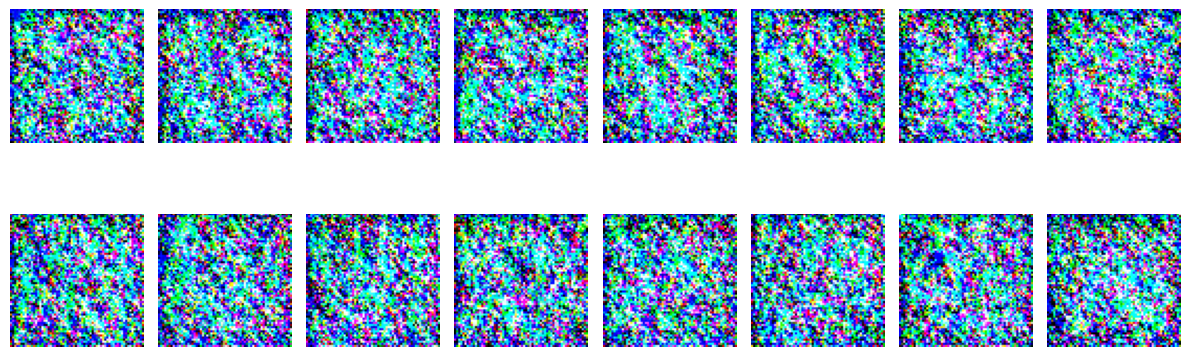

In [77]:
diffusion_model.plot_images()